In [2]:
# import yfinance as yf
# import datetime
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


In [6]:
def get_price_hist(ticker):
    today = datetime.today().strftime("%d/%m/%Y")
    today = datetime.strptime(today + " +0000", "%d/%m/%Y %z")
    to = int(today.timestamp())
    # Get date ten years ago as UTC timestamp
    # time_ago = today-relativedelta(years=30)
    # fro = int(time_ago.timestamp())
    time_ago = datetime(1959,1,1)
    fro = int(time_ago.timestamp())
    # Put stock price data in dataframe
    url = "https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={fro}&period2={to}&interval=1d&events=history".format(ticker=ticker, fro=fro, to=to)
    data = pd.read_csv(url)
    
    # Convert date to timestamp and make index
    data.index = data["Date"].apply(lambda x: pd.Timestamp(x))
    data.drop("Date", axis=1, inplace=True)

    return data

In [102]:
# ticker= "^GSPC"
ticker='MVIS'
# ticker='GME'
ticker_history = get_price_hist(ticker)
ticker_history = ticker_history["Close"]
ticker_history = pd.DataFrame(ticker_history)

In [103]:
def rsi(data: pd.Series, period=14):
    
   diff = data.diff()
   up, down = diff.copy(), diff.copy()
   up[up < 0] = 0
   down[down > 0] = 0
   up_ewm = up.ewm(com=(period - 1), min_periods=period).mean()
   down_ewm = down.abs().ewm(com=(period - 1),\
                             min_periods=period).mean()
   RS = up_ewm / down_ewm
   return pd.Series(100 - (100 / (1 + RS)))
ticker_history_rsi = ticker_history.apply(rsi)
ticker_history_rsi = ticker_history_rsi.dropna()

In [118]:
#horizons
# horizons = [1,4,12,52]#,104,156, 260, 520]
horizons = [1,2,3,5,10]
freq='YS'#'W' #for the pd.date_range
# period='weeks'
#starting dates
start_date =  datetime(2002,3,28)
last_date = datetime.today() #datetime(2021,1,1)
dates = pd.date_range(start_date,last_date,freq='YS')#freq='YS'
dates = dates[:-1]
#results dataframe initialization
index = pd.MultiIndex.from_product([dates, horizons],
                                   names=['dates', 'horizon'])   
results = pd.DataFrame(index=index,columns=["Buy & Hold"])

In [119]:
last_date

datetime.datetime(2021, 4, 30, 6, 17, 30, 816189)

In [120]:
#buy and hold computation
def buy_and_hold(row):
        
    horizon = row.name[1]
    buy_date = row.name[0]
    sell_date = buy_date + relativedelta(years=horizon) #years
    
    if sell_date > last_date:
        return None
    else:
        prices = ticker_history[(ticker_history.index>=buy_date)&(ticker_history.index<sell_date)]
        return (prices.iloc[-1]/prices.iloc[0] - 1)*100

        
results["Buy & Hold"] = results.apply(buy_and_hold,axis=1)

In [121]:
def buy_cheap_and_hold(row):
        
    horizon = row.name[1]
    horizon_start = row.name[0]
    sell_date = horizon_start + relativedelta(years=horizon)
    
    if sell_date > last_date:
        return None
    else:
        
        prices = ticker_history[(ticker_history.index>=horizon_start)&
                             (ticker_history.index<sell_date)]
        rsi = ticker_history_rsi[\
              (ticker_history_rsi.index>=horizon_start)\
              &(ticker_history_rsi.index<sell_date)]
        
        rsi30_cumsum = (rsi < 30).cumsum()
        first_rsi30 = rsi30_cumsum.apply(lambda x: x[(x==1)&\
                      ((x.diff()==1)|(x.diff().isna()))])
        try:
            buy_price = prices[prices.index==first_rsi30.index[0]]  
            return 100*(prices.iloc[-1,0] / \
                        buy_price.iloc[-1,0] - 1)
            
        except:
            return 0 
        
        
results["Buy cheap & Hold"] = results.apply(buy_cheap_and_hold,axis=1)


In [122]:
def buy_not_expensive_and_hold(row):
        
    horizon = row.name[1]
    horizon_start = row.name[0]
    sell_date = horizon_start + relativedelta(years=horizon)
    
    if sell_date > last_date:
        return None
    else:
        
        prices = ticker_history[(ticker_history.index>=horizon_start)&
                             (ticker_history.index<sell_date)]
        rsi = ticker_history_rsi[\
              (ticker_history_rsi.index>=horizon_start)\
              &(ticker_history_rsi.index<sell_date)]
        
        rsi70_cumsum = (rsi < 70).cumsum()
        first_rsi70 = rsi70_cumsum.apply(lambda x: x[(x==1)&\
                      ((x.diff()==1)|(x.diff().isna()))])
        try:
            buy_price = prices[prices.index==first_rsi70.index[0]]  
            return 100*(prices.iloc[-1,0] / \
                        buy_price.iloc[-1,0] - 1)
            
        except:
            return 0         
        
results["Buy not expensive & Hold"] = results.apply(buy_not_expensive_and_hold,axis=1)


In [123]:
import sys#, threading
sys.setrecursionlimit(10**7) # max depth of recursion

In [ ]:
def buy_cheap_sell_expensive_recursive(horizon_start,horizon_end):
    

    prices = ticker_history[(ticker_history.index>=horizon_start)\
                         &(ticker_history.index<horizon_end)]
    rsi = ticker_history_rsi[(ticker_history_rsi.index>=horizon_start)\
                          &(ticker_history_rsi.index<horizon_end)]
    #buy price
    rsi30_cumsum = (rsi < 30).cumsum()
    first_rsi30 = rsi30_cumsum.apply(lambda x: x[(x==1)\
                  &((x.diff()==1)|(x.diff().isna()))])
    
    try:
        buy_price = prices[prices.index==first_rsi30.index[0]]  
    except:
        return 1
    
    #sell price
    sell_horizon_prices = prices[prices.index > buy_price.index[0]]
    sell_horizon_rsi = rsi[rsi.index > buy_price.index[0]]
    
    rsi70_cumsum = (sell_horizon_rsi > 70).cumsum()
    first_rsi70 = rsi70_cumsum.apply(lambda x: x[(x==1)\
                    &((x.diff()==1)|(x.diff().isna()))])
    
    try:
        sell_prices = prices[prices.index==first_rsi70.index[0]]
    except:
        sell_prices = prices[prices.index==prices.index[-1]]
        
    performance = sell_prices.iloc[-1,0] / buy_price.iloc[-1,0]
    
    return performance*\
                        buy_cheap_sell_expensive_recursive(\
                        sell_prices.index[0],\
                        horizon_end)
def buy_cheap_sell_expensive(row):
    
    horizon = row.name[1]
    horizon_start = row.name[0]
    horizon_end = horizon_start + relativedelta(years=horizon)
    
    return 100*(buy_cheap_sell_expensive_recursive\
               (horizon_start,horizon_end)- 1)
results["Buy cheap Sell expensive"] = results.apply(buy_cheap_sell_expensive,axis=1)

In [75]:
# results_SPY=results.copy()

In [89]:
# results_MVIS=results.copy()

In [1]:
for horizon in horizons:
    
    data=results.loc(axis=0)[:, [horizon]]
    data_stacked=data.stack()
    data_stacked=data_stacked.reset_index()
    data_stacked.columns=['dates', 'horizon', 'strategy', 'return']
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)

    # ax = sns.boxplot(data=data, orient="h", palette="Set2")
    ax = sns.swarmplot(x="return", y="strategy", data=data_stacked, color=None,size=4, edgecolor='gray',linewidth=0.75)
    ax = sns.violinplot(x="return", y="strategy", data=data_stacked, inner=None)
    ax.set_title('{} returns vs investment strategy for {} {} horizon'.format(ticker, horizon, freq))
    plt.tight_layout()
plt.show()

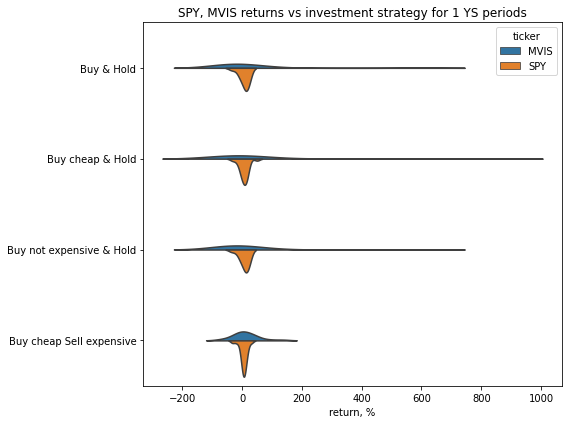

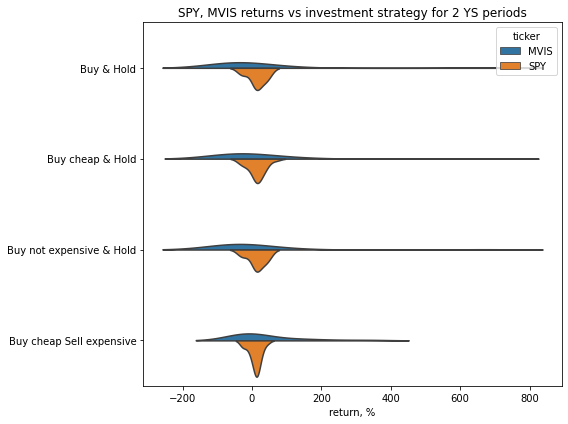

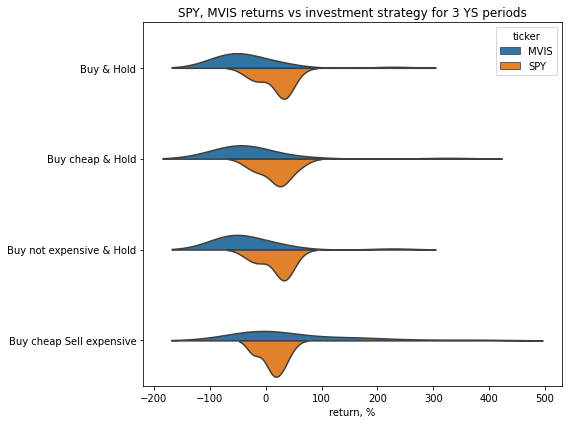

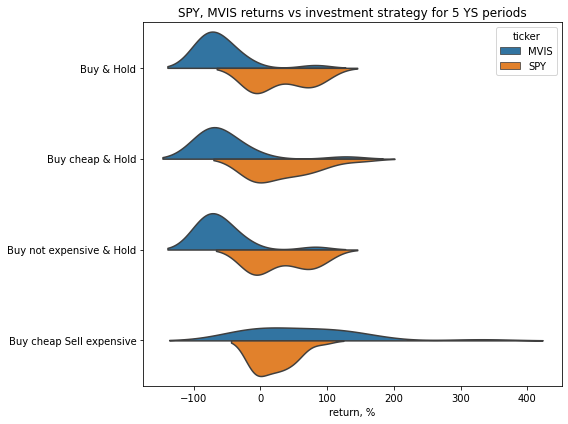

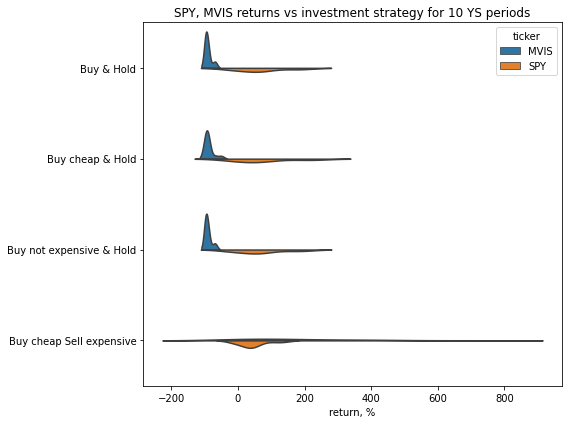

In [113]:
for horizon in horizons:
    
    
    # data_MVIS=results_MVIS.loc(axis=0)[:, [horizon]]
    # data_stacked_MVIS=data_MVIS.stack()
    # data_stacked_MVIS=data_stacked_MVIS.reset_index()
    # print(data_stacked_MVIS)

    data_SPY=results_SPY.loc(axis=0)[:, [horizon]]
    data_stacked_SPY=data_SPY.stack()
    data_stacked_SPY=data_stacked_SPY.reset_index()
    data_stacked_SPY.columns=['dates', 'horizon', 'strategy', 'return']
    data_stacked_SPY.insert(loc=2, column='ticker', value='SPY')
    # print(data_stacked_SPY.head())

    data_MVIS=results_MVIS.loc(axis=0)[:, [horizon]]
    data_stacked_MVIS=data_MVIS.stack()
    data_stacked_MVIS=data_stacked_MVIS.reset_index()
    data_stacked_MVIS.columns=['dates', 'horizon', 'strategy', 'return']
    data_stacked_MVIS.insert(loc=2, column='ticker', value='MVIS')
    # print(data_stacked_MVIS.head())
    data_stacked=pd.concat([data_stacked_MVIS, data_stacked_SPY])
    # print(data_stacked.sample())

    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)

    # ax = sns.boxplot(data=data, orient="h", palette="Set2")
    # ax = sns.swarmplot(x="return", y="strategy", data=data_stacked, color=None,size=4, edgecolor='gray',linewidth=0.75)
    ax = sns.violinplot(x="return", y="strategy", data=data_stacked, inner=None, scale_hue=False, hue='ticker', split=True)
    ax.set_xlabel('return, {}'.format('%'))
    ax.set_ylabel('')
    ax.set_title('{} returns vs investment strategy for {} {} periods'.format('SPY, MVIS', horizon, freq))
    plt.tight_layout()
    plt.savefig(r'/content/drive/MyDrive/Colab Notebooks/market_timing_images/{}_horizon_{}.jpg'.format('SPY_MVIS', horizon), dpi=600)
plt.show()

data_SPY=results_SPY.loc(axis=0)[:, [horizon]]
    data_stacked_SPY=data_SPY.stack()
    data_stacked_MVIS=data_stacked_MVIS.reset_index()
    data_stacked_MVIS.columns=['dates', 'horizon', 'strategy', 'return']
    data_stacked_MVIS.insert(loc=2, column='ticker', value='MVIS')
    print(data_stacked_MVIS)

In [99]:
import cv2, os
from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize

In [100]:
def make_video(images, outimg=None, fps=0.5, size=None,
               is_color=True, format="XVID"):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
 
    The function relies on http://opencv-python-tutroals.readthedocs.org/en/latest/.
    By default, the video will have the size of the first image.
    It will resize every image to this size before adding them to the video.
    """
    fourcc = VideoWriter_fourcc(*format)
    outvid=r'/content/drive/MyDrive/Colab Notebooks/market_timing_images/SPY_MVIS.avi'
    vid = None
    for image in images:
        image=r'/content/drive/MyDrive/Colab Notebooks/market_timing_images/{}_horizon_{}.jpg'.format('SPY_MVIS', image)
        if not os.path.exists(image):
#             raise FileNotFoundError(image)
            print(image, "not found")
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

In [117]:
make_video([1, 2, 3, 5, 10, 11])

<VideoWriter 0x7f1b1aa28f30>